# Compare offline turbulence to observations
### function of wind shear and temperature gradient

In [1]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc


# -------------------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('talk')
import string
alphabet = list(string.ascii_lowercase)

# -------------------------------------------------------------------------------------------------------
# Directories
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirDataSCP = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

### Surface observations

In [2]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

# Indices of simulated turbulence times (observations exist, wind > 2m/s, snow is present)
# SNQind = np.nonzero((SNQ.SP == 1).values &
#                     (SNQ.WIND > 2).values &
#                     (~(np.isnan(SNQ.SensFlux)).values |
#                     ~(np.isnan(SNQ.LatFlux)).values))
RiBulk_SNQ, _, _ = turbpy.bulkRichardson(SNQ.T6 + 273.15, SNQ.Tsrf + 273.15,SNQ.WIND, 6.)
SNQ['RiBulk'] = RiBulk_SNQ
SNQind = np.nonzero((SNQ.WIND > .2).values & (~(np.isnan(SNQ.SensFlux)).values) & (SNQ.RiBulk > 0).values)

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
SCP['w_tc__2m'] = fluxObs.w_tc__2m_M
SCP['w_tc_10m'] = fluxObs.w_tc__10m_M

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind speed magnitude
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_15m > 10] = np.nan
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_2m > 10] = np.nan

# Bulk Richardson number
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

# Indices of stable periods (simulated)
SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1144: RuntimeWarning: divide by zero encountered in true_divide
  else f(other_data, self_data))
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [3]:
os.chdir(dirProj)
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov')

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
SNQ_sensible = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
SNQ_latent = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
SCP_sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
SCP_sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
SCP_latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
SCP_latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

os.chdir(dirPrint)

# Temperature Gradient

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


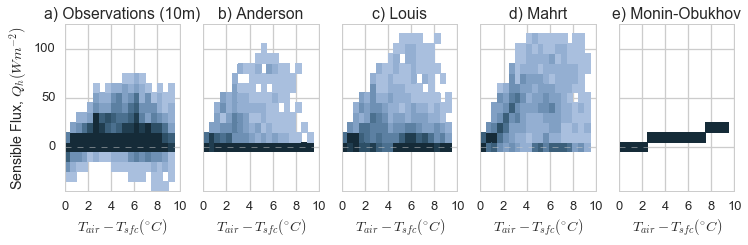

In [4]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -45
ymax = 125
xmin = 0
xmax = 10
dy = 10
dx = .5

# Format figure
## General colorbar arguments
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
axes = axes.flatten()

# Observed turbulence
ax = axes[0]

# Build my own histogram
X = (SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind]).values.flatten()
Y = -SCP.w_tc_10m[SCPind].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('$T_{air} - T_{sfc} (^{\circ} C)$')
ax.grid()
axes[0].set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix + 1]
    
    # Build my own histogram
    X = (SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind]).values.flatten()
    Y = SCP_sensible_15m[stab].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + ixStabilityTitles[ix])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('$T_{air} - T_{sfc} (^{\circ}C)$')
    ax.grid()
fig.savefig('OfflineTurb.SCP_15m.2dHist_TempGrad.pdf')

# -------------------------------------------------------------------------------------------------------
# SNQ
# This broke when re-running (03/10/17). The existing figure is still there. Probably something to do with not 
# indexing the data correctly. Definitely not a high priority fix.
# ymin = -50
# ymax = 100
# dy = 10
# xmin = 0
# xmax = 10
# dx = .5

# fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
# axes = axes.flatten()
# # Simulated turbulence
# for ix, stab in enumerate(ixStability):
#     ax = axes[ix]
#     ax.hist2d(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ_sensible[stab].values,
#               bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#               cmap=cmap, vmin=5, vmax=20)
#     ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
#     ax.set_title(stab)
#     ax.set_ylim(ymin, ymax)
#     ax.set_xlabel('$T_{air} - T_{sfc} (\circ^{C})$')
# # Observed turbulence
# ax = axes[-1]
# ax.hist2d(SNQ.T6[SNQind] - SNQ.Tsrf[SNQind], SNQ.SensFlux[SNQind],
#           bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#           cmap=cmap, vmin=5, vmax=20)
# ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
# ax.set_title('Observations (2m)')
# ax.set_xlabel('$T_{air} - T_{sfc} (^{\circ}C)$')
# fig.savefig('OfflineTurb.SNQ.2dHist_TempGrad.pdf')


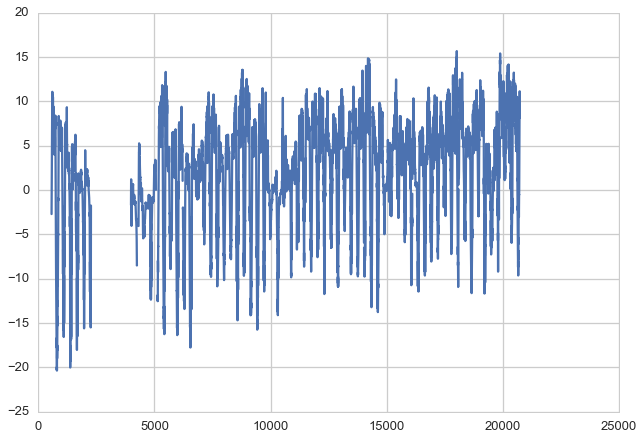

In [17]:
SCPtemp = SCP
SCPtemp['tempGrad'] = (SCP.T_15m_M - SCP.Tsfc)
plt.plot(SCPtemp.tempGrad)

[  7.39463393e+01   1.03494901e+01   3.36940316e+00  -2.35866981e+00
  -3.75061658e+00  -7.78746663e+00  -1.07015618e+01  -1.64855692e+01
  -1.67954863e+01  -1.90486682e+01  -2.01496227e+01  -1.64473348e+01
  -1.54018813e+01  -1.27059238e+01  -1.46685847e+01  -1.22608935e+01
  -9.55322194e+00  -8.28806769e+00  -6.22670888e+00   2.18253077e-02
  -3.09542975e+00]


//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


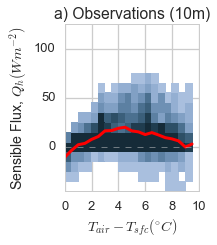

In [20]:
# Group a variable according to a proxy variable (e.g., group air temperature according to the stability)
def proxyGroupby(ds, binVar, binVals, digitVar):
    proxyGroups = np.digitize(ds[binVar].values, binVals, right=False)
    groupVar = np.zeros(np.size(binVals))
    for bnum, bV in enumerate(binVals):
        groupVar[bnum] = np.nanmean(ds[digitVar][proxyGroups == bnum])
    return groupVar

binTempGrad = np.arange(-0.5, 10, 0.5)
groupQh = proxyGroupby(SCPtemp, 'tempGrad', binTempGrad, 'w_tc_10m')
print(groupQh)

# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -45
ymax = 125
xmin = 0
xmax = 10
dy = 10
dx = .5

# Format figure
## General colorbar arguments
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)
fig, ax = plt.subplots(1, 1, figsize=(12/5, 3), sharex='col', sharey='row')

# Observed turbulence

# Build my own histogram
X = (SCP.T_15m_M[SCPind] - SCP.Tsfc[SCPind]).values.flatten()
Y = -SCP.w_tc_10m[SCPind].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
ax.plot(binTempGrad, -groupQh, 'r', linewidth=3)

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('$T_{air} - T_{sfc} (^{\circ} C)$')
ax.grid()
ax.set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')

fig.savefig('OfflineTurb.Obs.SCP_15m.2dHist_TempGrad.pdf', bbox_inches='tight')

# Wind

#### Notes:
- No obvious functional relationship between observed turbulence and wind
- Assumed form of relationship between simulated turbulence and wind in the bulk aerodynamic formulas does not appear in the observations
- SNQ has the same pattern between simulations and observations

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


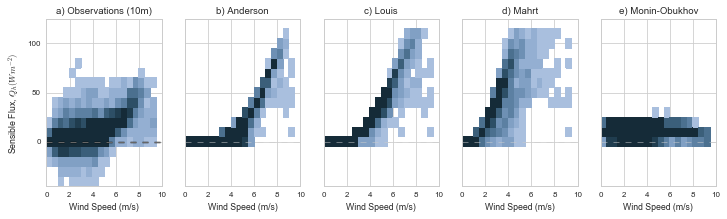

In [44]:
# -------------------------------------------------------------------------------------------------------
# SCP
ymin = -45
ymax = 125
xmin = 0
xmax = 10

# Figure formatting
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
axes = axes.flatten()
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Observed turbulence
ax = axes[0]

# Build my own histogram
X = SCP.UBar_15m[SCPind].values.flatten()
Y = -SCP.w_tc_10m[SCPind].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                               np.arange(ymin, ymax, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)

# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)


ax.plot([xmin, xmax], [0, 0], 'k--')
ax.set_title('a) Observations (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Wind Speed (m/s)')
ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.grid()
axes[0].set_ylabel('Sensible Flux, $Q_h (Wm^{-2})$')

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix + 1]

    # Build my own histogram
    X = SCP.UBar_15m[SCPind].values.flatten()
    Y = SCP_sensible_15m[stab].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin + dcol)
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)

    ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
    ax.set_title(alphabet[ix + 1] + ') ' + ixStabilityTitles[ix])
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Wind Speed (m/s)')
    ax.grid()
fig.savefig('OfflineTurb.SCP_15m.2dHist_Shear.pdf')

# -------------------------------------------------------------------------------------------------------
# SNQ
# ymin = -50
# ymax = 100
# dy = 10
# xmin = 2
# xmax = 4
# dx = .2

# fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex='col', sharey='row')
# axes = axes.flatten()
# # Simulated turbulence
# for ix, stab in enumerate(ixStability):
#     ax = axes[ix]
#     ax.hist2d(SNQ.WIND[SNQind], SNQ_sensible[stab].values,
#               bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#               cmap=cmap, vmin=5, vmax=20)
#     ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
#     ax.set_title(stab)
#     ax.set_ylim(ymin, ymax)
#     ax.set_xlim(xmin, xmax)
#     ax.set_xlabel('Wind Speed (m/s)')
# # Observed turbulence
# ax = axes[-1]
# ax.hist2d(SNQ.WIND[SNQind], SNQ.SensFlux[SNQind].values,
#           bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)),
#           cmap=cmap, vmin=5, vmax=20)
# ax.plot([xmin, xmax], [0, 0], 'k--', linewidth=.5)
# ax.set_title('Observations (2m)')
# ax.set_xlabel('Wind Speed (m/s)')
# ax.set_xlim(xmin, xmax)
# axes[0].set_ylabel('Sensible Flux (Wm-2)')
# fig.savefig('OfflineTurb.SNQ.2dHist_Shear.pdf')